#  CSTR fault detection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.io
import matplotlib.image as mpimg

/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


(-0.5, 1096.5, 551.5, -0.5)

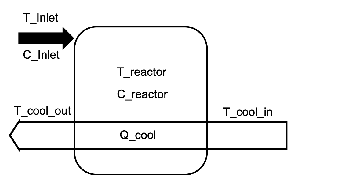

In [2]:
cstr= mpimg.imread('cstr.png')
plt.imshow(cstr)
plt.axis('off')

In [3]:
## Import data
mat = scipy.io.loadmat('cstr_fault_time_series.mat')


In [200]:
## make data into pandas
fault_label=mat["fault_labels"].flatten()
data = pd.DataFrame({'C_inlet':mat["data"][:, 0], 'T_inlet':mat["data"][:, 1] \
                     ,'C_reactor':mat["data"][:, 2], 'T_reactor':mat["data"][:, 3] \
                     ,'Q_cool':mat["data"][:, 4], 'T_cool_in':mat["data"][:, 5]\
                     ,'T_cool_out':mat["data"][:, 6],'fault':fault_label
                    
                    })
data['heat']=data['Q_cool']*(data['T_cool_out']-data['T_cool_in'])
data = data[["C_inlet","C_reactor","Q_cool","T_cool_in","T_cool_out",\
             "T_inlet","T_reactor","heat","fault"]]
data.head()

,C_inlet,C_reactor,Q_cool,T_cool_in,T_cool_out,T_inlet,T_reactor,heat,fault
0,1.027647,0.099224,148.841248,348.638761,416.686204,350.360361,430.879667,10128.266233,0
1,1.027779,0.094646,157.013774,348.713451,417.987404,350.299300,432.911189,10876.964729,0
2,1.026808,0.108838,154.560242,349.188551,414.600037,349.971868,429.661746,10110.015071,0
3,1.026215,0.097684,157.220063,348.729069,416.656083,350.640629,432.256645,10679.489263,0
4,1.026132,0.100689,162.379105,348.849656,416.179071,350.595431,431.304828,10932.890056,0


In [5]:
## seperte  based on fault
normal=data[data['fault']==0]
normal = normal.drop('fault', 1)
normal['heat']=normal['Q_cool']*(normal['T_cool_out']-normal['T_cool_in'])


In [6]:
## seperte  based on fault
f1=data[data['fault']==1]
f1=f1.drop('fault', 1)

f2=data[data['fault']==2]
f2=f2.drop('fault', 1)

f3=data[data['fault']==3]
f3=f3.drop('fault', 1)

f4=data[data['fault']==4]
f4=f4.drop('fault', 1)

f5=data[data['fault']==5]
f5=f5.drop('fault', 1)

In [7]:
corr = normal.corr()
corr.style.background_gradient(cmap=cm.plasma)

,C_inlet,C_reactor,Q_cool,T_cool_in,T_cool_out,T_inlet,T_reactor,heat
C_inlet,1,0.337727,0.865872,-0.103169,-0.430025,-0.14273,0.0325988,0.790347
C_reactor,0.337727,1,0.160318,-0.0381804,-0.958128,-0.0298583,-0.904093,-0.163197
Q_cool,0.865872,0.160318,1,0.143554,-0.30809,0.0522386,0.19717,0.915468
T_cool_in,-0.103169,-0.0381804,0.143554,1,0.0407638,0.0529842,-0.00447289,-0.0825254
T_cool_out,-0.430025,-0.958128,-0.30809,0.0407638,1,-0.0336354,0.85825,0.0189059
T_inlet,-0.14273,-0.0298583,0.0522386,0.0529842,-0.0336354,1,-0.0174267,0.0301891
T_reactor,0.0325988,-0.904093,0.19717,-0.00447289,0.85825,-0.0174267,1,0.516496
heat,0.790347,-0.163197,0.915468,-0.0825254,0.0189059,0.0301891,0.516496,1


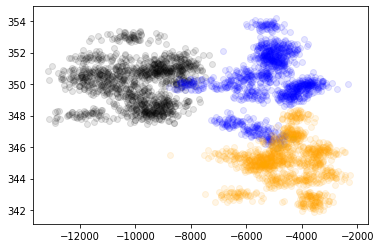

In [8]:
plt.scatter(normal['C_inlet']*(normal['Q_cool']*(normal['T_cool_in']-normal['T_cool_out']) )   ,normal['T_inlet'],alpha=0.1,c='k')
#plt.scatter(f1['C_inlet'],f1['T_inlet'],alpha=0.1,c='r')
plt.scatter(f2['C_inlet']   *(f2['Q_cool']*(f2['T_cool_in']-f2['T_cool_out'])    )  ,f2['T_inlet'],alpha=0.1,c='b')
#plt.scatter(f3['C_inlet'],f3['T_inlet'],alpha=0.1,c='g')
#plt.scatter(f4['C_inlet'],f4['T_inlet'],alpha=0.1,c='yellow')
plt.scatter(f5['C_inlet']  *(f5['Q_cool']*(f5['T_cool_in']-f5['T_cool_out'])  )      ,f5['T_inlet'],alpha=0.1,c='orange')


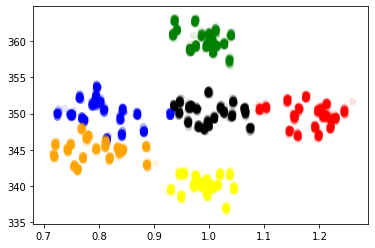

In [82]:
plt.scatter(normal['C_inlet'],normal['T_inlet'],alpha=0.1,c='k')
plt.scatter(f1['C_inlet'],f1['T_inlet'],alpha=0.1,c='r')
plt.scatter(f3['C_inlet'],f3['T_inlet'],alpha=0.1,c='g')
plt.scatter(f2['C_inlet'],f2['T_inlet'],alpha=0.1,c='b')
plt.scatter(f4['C_inlet'],f4['T_inlet'],alpha=0.1,c='yellow')
plt.scatter(f5['C_inlet'],f5['T_inlet'],alpha=0.1,c='orange')

In [83]:
### classfication 
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score


In [110]:
n_feature=5
h = .02  # step size in the mesh
h=0.02
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=int(np.sqrt(5))),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
     QuadraticDiscriminantAnalysis()]
names = [ "RBF SVM","Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]
classifiers = [SVC(gamma=2, C=1), DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=int(np.sqrt(5))),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
     QuadraticDiscriminantAnalysis()]

In [111]:
datasets = [data[["C_inlet","T_inlet"]].values,np.ndarray.flatten(data[["fault"]].values)
            ]

In [112]:
X,y=datasets
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
  

In [87]:
type(zip([1,2,3], [101,102,103]))

zip

In [88]:
 cm_bright = ListedColormap(['#FF0000', '#0000FF'])

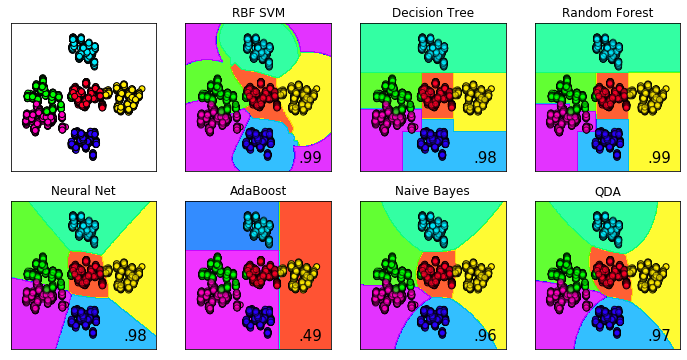

In [89]:
figure = plt.figure(figsize=( 12,4*len(names)*0+6 ))
i = 1
ax = plt.subplot( len(classifiers) *0+ 1*0+2,1*0+4, i)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train/5, cmap=cm.gist_rainbow, alpha=1, edgecolors='k')
    # Plot the testing points
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test/5, cmap=cm.gist_rainbow, alpha=1,edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())
i = i+1
for name, clf in zip(names, classifiers):
    ax = plt.subplot(len(classifiers) *0+ 1*0+2,1*0+4, i)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    #if hasattr(clf, "decision_function"):
     #   Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    #else:
     #   Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 5]
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm.gist_rainbow, alpha=.8)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm.gist_rainbow,
               edgecolors='k')
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm.gist_rainbow,
               edgecolors='k', alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
    i=i+1
       
#plt.tight_layout()
#plt.show()

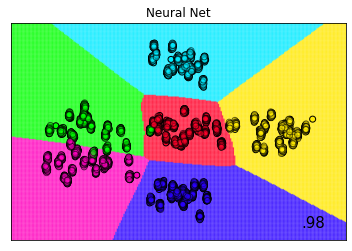

In [118]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=int(np.sqrt(5))),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
     QuadraticDiscriminantAnalysis()]

names = ["Neural Net"]
classifiers = [
MLPClassifier(alpha=1, max_iter=1000)
   ]


figure = plt.figure()
for name, clf in zip(names, classifiers):
    ax = plt.subplot()
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    #if hasattr(clf, "decision_function"):
     #   Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    #else:
     #   Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 5]
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
   # ax.contourf(xx, yy, Z, cmap=cm.gist_rainbow, alpha=.8)
    ax.scatter(xx.ravel(), yy.ravel(), c=Z.ravel(), cmap=cm.gist_rainbow, alpha=.8,s=0.2)
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm.gist_rainbow,
               edgecolors='k')
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm.gist_rainbow,
               edgecolors='k', alpha=0.6)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
       
#plt.tight_layout()
#plt.show()

In [193]:
array=data.values

In [201]:
from pandas import read_csv
from sklearn.ensemble import ExtraTreesClassifier

array=data.values
X = array[:,0:8]
Y = array[:,8]
# feature extraction
model = ExtraTreesClassifier(n_estimators=10)
model.fit(X, Y)
print(model.feature_importances_)


[0.255 0.014 0.161 0.036 0.034 0.39  0.015 0.095]


In [204]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
X = array[:,0:8]
Y = array[:,8]
# feature extraction
model = LogisticRegression(solver='lbfgs')
rfe = RFE(model, 2)
fit = rfe.fit(X, Y)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)


/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the

Num Features: 2
Selected Features: [ True  True False False False False False False]
Feature Ranking: [1 1 6 2 4 3 5 7]


/anaconda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [202]:
data.head()

,C_inlet,C_reactor,Q_cool,T_cool_in,T_cool_out,T_inlet,T_reactor,heat,fault
0,1.027647,0.099224,148.841248,348.638761,416.686204,350.360361,430.879667,10128.266233,0
1,1.027779,0.094646,157.013774,348.713451,417.987404,350.299300,432.911189,10876.964729,0
2,1.026808,0.108838,154.560242,349.188551,414.600037,349.971868,429.661746,10110.015071,0
3,1.026215,0.097684,157.220063,348.729069,416.656083,350.640629,432.256645,10679.489263,0
4,1.026132,0.100689,162.379105,348.849656,416.179071,350.595431,431.304828,10932.890056,0


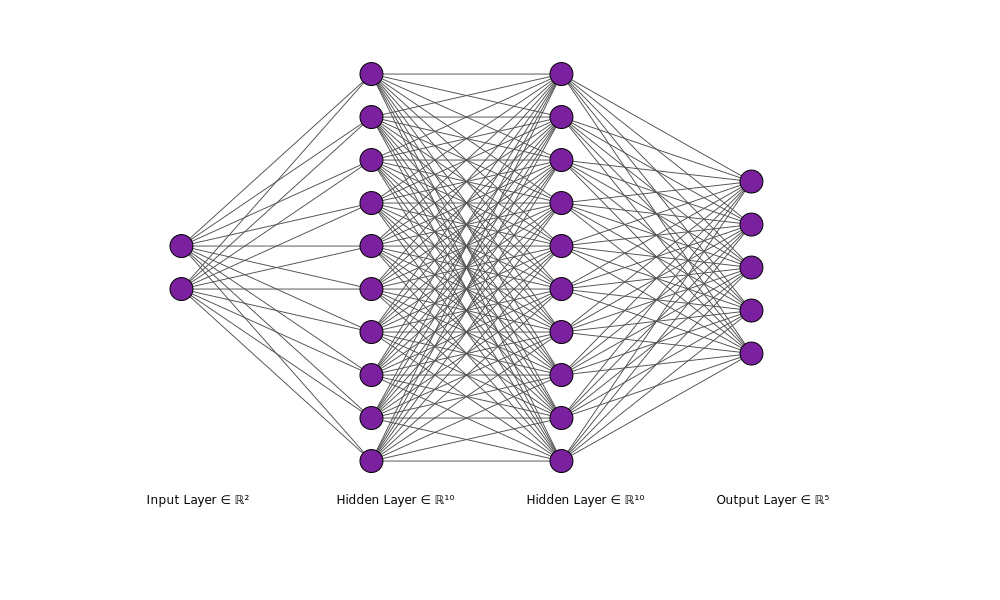

In [16]:
from IPython.display import SVG
SVG('ANN.svg')

In [206]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import SGD

In [207]:
datasets = [data[["C_inlet","C_reactor"]].values,np.ndarray.flatten(data[["fault"]].values)
            ]
X,y=datasets
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [208]:
#softmax,'rmsprop
model = Sequential()
model.add(Dense(8, activation='relu', input_dim=2))
model.add(Dense(10, activation='relu'))
model.add(Dense(6, activation='softmax'))   # Final Layer using Softmax
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
Y_train = keras.utils.to_categorical(y_train, num_classes=6)
Y_test = keras.utils.to_categorical(y_test, num_classes=6)
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=20, batch_size=64)
score = model.evaluate(X_test, Y_test, batch_size=64)

Epoch 1/20
4323/4323 [==============================] - 0s 60us/sample - loss: 1.5865 - accuracy: 0.2494
Epoch 2/20
4323/4323 [==============================] - 0s 16us/sample - loss: 1.1844 - accuracy: 0.3636
Epoch 3/20
4323/4323 [==============================] - 0s 15us/sample - loss: 1.0351 - accuracy: 0.4404
Epoch 4/20
4323/4323 [==============================] - 0s 15us/sample - loss: 0.9657 - accuracy: 0.4673
Epoch 5/20
4323/4323 [==============================] - 0s 14us/sample - loss: 0.9246 - accuracy: 0.4830
Epoch 6/20
4323/4323 [==============================] - 0s 13us/sample - loss: 0.8993 - accuracy: 0.4807
Epoch 7/20
4323/4323 [==============================] - 0s 13us/sample - loss: 0.8798 - accuracy: 0.4837
Epoch 8/20
4323/4323 [==============================] - 0s 14us/sample - loss: 0.8654 - accuracy: 0.4999
Epoch 9/20
4323/4323 [==============================] - 0s 13us/sample - loss: 0.8544 - accuracy: 0.4966
Epoch 10/20
4323/4323 [==============================] 

In [156]:
weights, biases = model.layers[0].get_weights()
np.mean(weights,1)


array([ 0.21615486,  0.33539227, -0.10210754, -0.10360897], dtype=float32)

In [157]:
weights, biases = model.layers[1].get_weights()
np.mean(weights,1)

array([ 0.13408232,  0.37047306,  0.16768643,  0.16434012,  0.19455388,
       -0.13165024, -0.01879795,  0.1398262 ], dtype=float32)

In [122]:
h=0.02
x0_min, x0_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
x1_min, x1_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

In [123]:

x0, x1 = np.meshgrid(np.arange(x0_min, x0_max, h),np.arange(x1_min, x1_max, h))

In [124]:
prediction = model.predict(np.c_[x0.ravel(), x1.ravel()])
z=np.argmax(prediction, axis=1)
z = z.reshape(x0.shape)

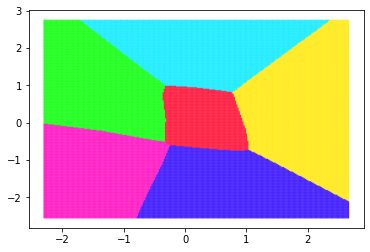

In [126]:
plt.scatter(x0.ravel(), x1.ravel(), c=Z.ravel(), cmap=cm.gist_rainbow, alpha=.8,s=0.2)

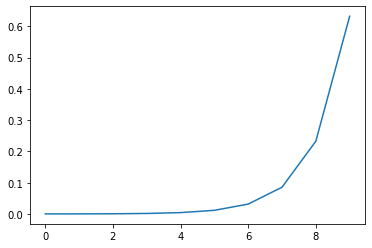

In [63]:
def softmax(scores):
    exp = np.exp(scores)
    scores = exp / np.sum(exp)
    return scores
plt.plot(softmax(np.arange(10)))

(400, 450)

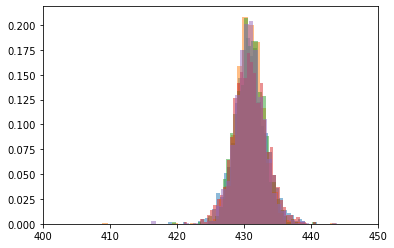

In [51]:
kwargs = dict(histtype='stepfilled', alpha=0.5, density=True, bins=40)
plt.hist(normal["T_reactor"],**kwargs);
#plt.hist(f1["T_reactor"], **kwargs);
plt.hist(f2["T_reactor"], **kwargs);
plt.hist(f3["T_reactor"], **kwargs);
plt.hist(f4["T_reactor"], **kwargs);
plt.hist(f5["T_reactor"], **kwargs);
plt.xlim(400,450)

In [59]:
from scipy import stats
t, p = stats.ttest_ind(f1["T_reactor"], normal["T_reactor"], equal_var=False)
[t,p]

[0.1698104177313349, 0.8651870772442143]

(420, 15000)

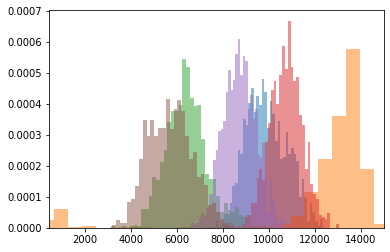

In [45]:
kwargs = dict(histtype='stepfilled', alpha=0.5, density=True, bins=40)
plt.hist(normal["heat"],**kwargs);
plt.hist(f1["heat"], **kwargs);
plt.hist(f2["heat"], **kwargs);
plt.hist(f3["heat"], **kwargs);
plt.hist(f4["heat"], **kwargs);
plt.hist(f5["heat"], **kwargs);
plt.xlim(420,15000)



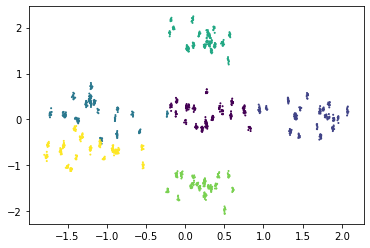

In [16]:
plt.scatter(X_test[:,0],X_test[:,1],c=y_test,cmap=cm.viridis,s=1)

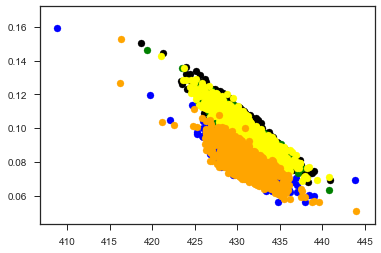

In [19]:
plt.scatter(normal['T_reactor'],normal['C_reactor'],c='k')
#plt.scatter(f1['T_reactor'],f1['C_reactor'],c='r')
plt.scatter(f2['T_reactor'],f2['C_reactor'],c='b')
plt.scatter(f3['T_reactor'],f3['C_reactor'],c='g')
plt.scatter(f4['T_reactor'],f4['C_reactor'],c='yellow')
plt.scatter(f5['T_reactor'],f5['C_reactor'],c='orange')



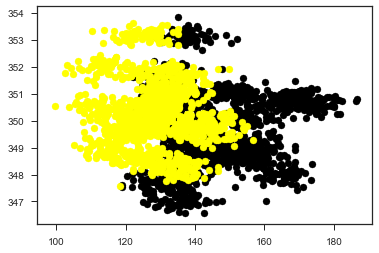

In [28]:
plt.scatter(normal['Q_cool'],normal['T_cool_in'],c='k')
#plt.scatter(f1['Q_cool'],f1['T_cool_in'],c='r')
#plt.scatter(f2['Q_cool'],f2['T_cool_in'],c='b')
#plt.scatter(f3['Q_cool'],f3['T_cool_in'],c='g')
plt.scatter(f4['Q_cool'],f4['T_cool_in'],c='yellow')
#plt.scatter(f5['Q_cool'],f5['T_cool_in'],c='orange')



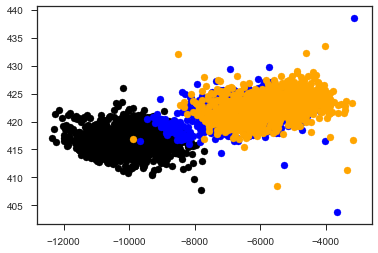

In [32]:
plt.scatter(normal['Q_cool']*(normal['T_cool_in']-normal['T_cool_out']),normal['T_cool_out'],c='k')
#plt.scatter(f1['Q_cool']*(f1['T_cool_in']-f1['T_cool_out']),f1['T_cool_out'],c='r')
plt.scatter(f2['Q_cool']*(f2['T_cool_in']-f2['T_cool_out']),f2['T_cool_out'],c='b')
#plt.scatter(f3['Q_cool']*(f3['T_cool_in']-f3['T_cool_out']),f3['T_cool_out'],c='g')
#plt.scatter(f4['Q_cool']*(f4['T_cool_in']-f4['T_cool_out']),f4['T_cool_out'],c='yellow')
plt.scatter(f5['Q_cool']*(f5['T_cool_in']-f5['T_cool_out']),f5['T_cool_out'],c='orange')

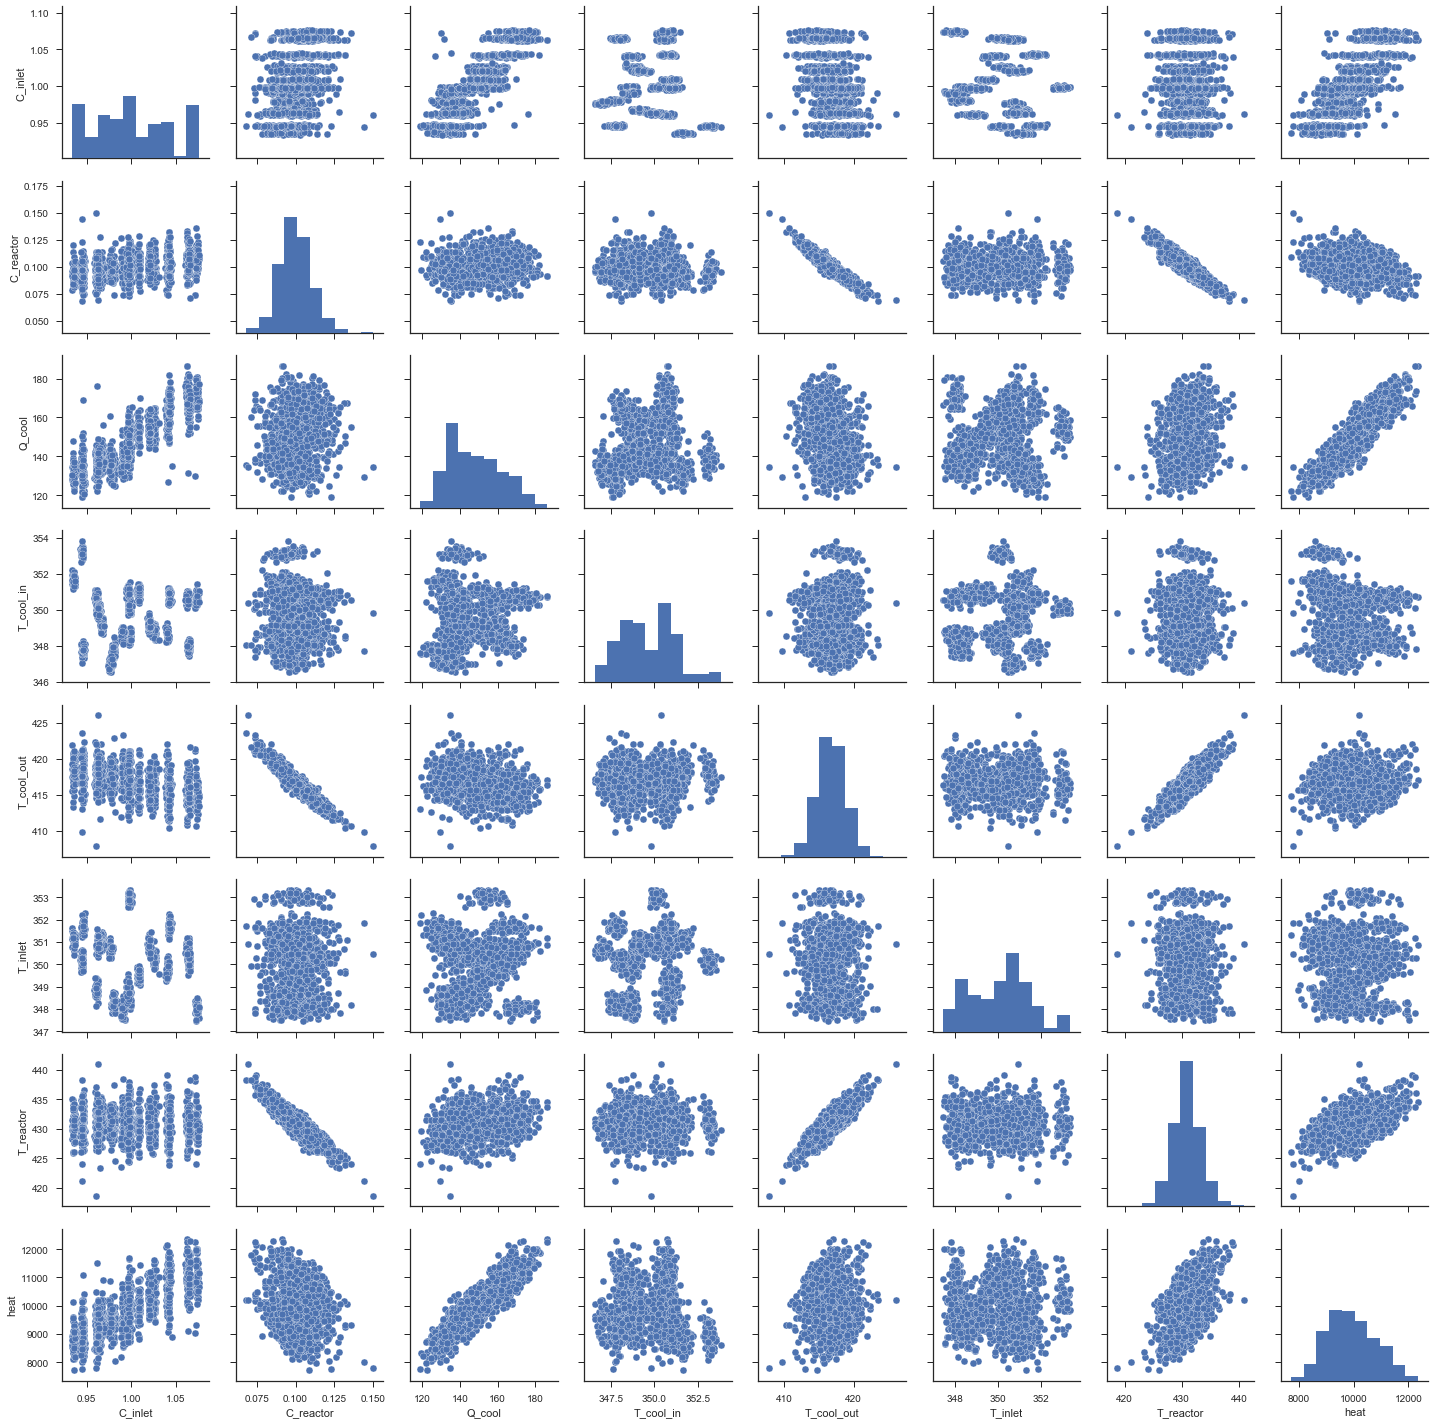

In [13]:
import seaborn as sns
sns.set(style="ticks")
sns.pairplot(normal)


## independent variavles is c_inlet,t_inlet, T_cool_in, 

## controllale varibles : Q_cool

### can the variable goes back to influence the previous one
##  Q_cool*( T_cool_in-T_cool_out)
## dependent variables : C_REACTOR -> t_REACTOR -> Q_cool*( T_cool_in-T_cool_out)
## THE PURPOSE IS TO KEEP A CONSTANT TENPEATURE

In [59]:

#from pandas.plotting import scatter_matrix
#scatter_matrix(normal, alpha=0.2, figsize=(6, 6), diagonal='kde')

/anaconda/lib/python3.6/site-packages/seaborn/distributions.py:400: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


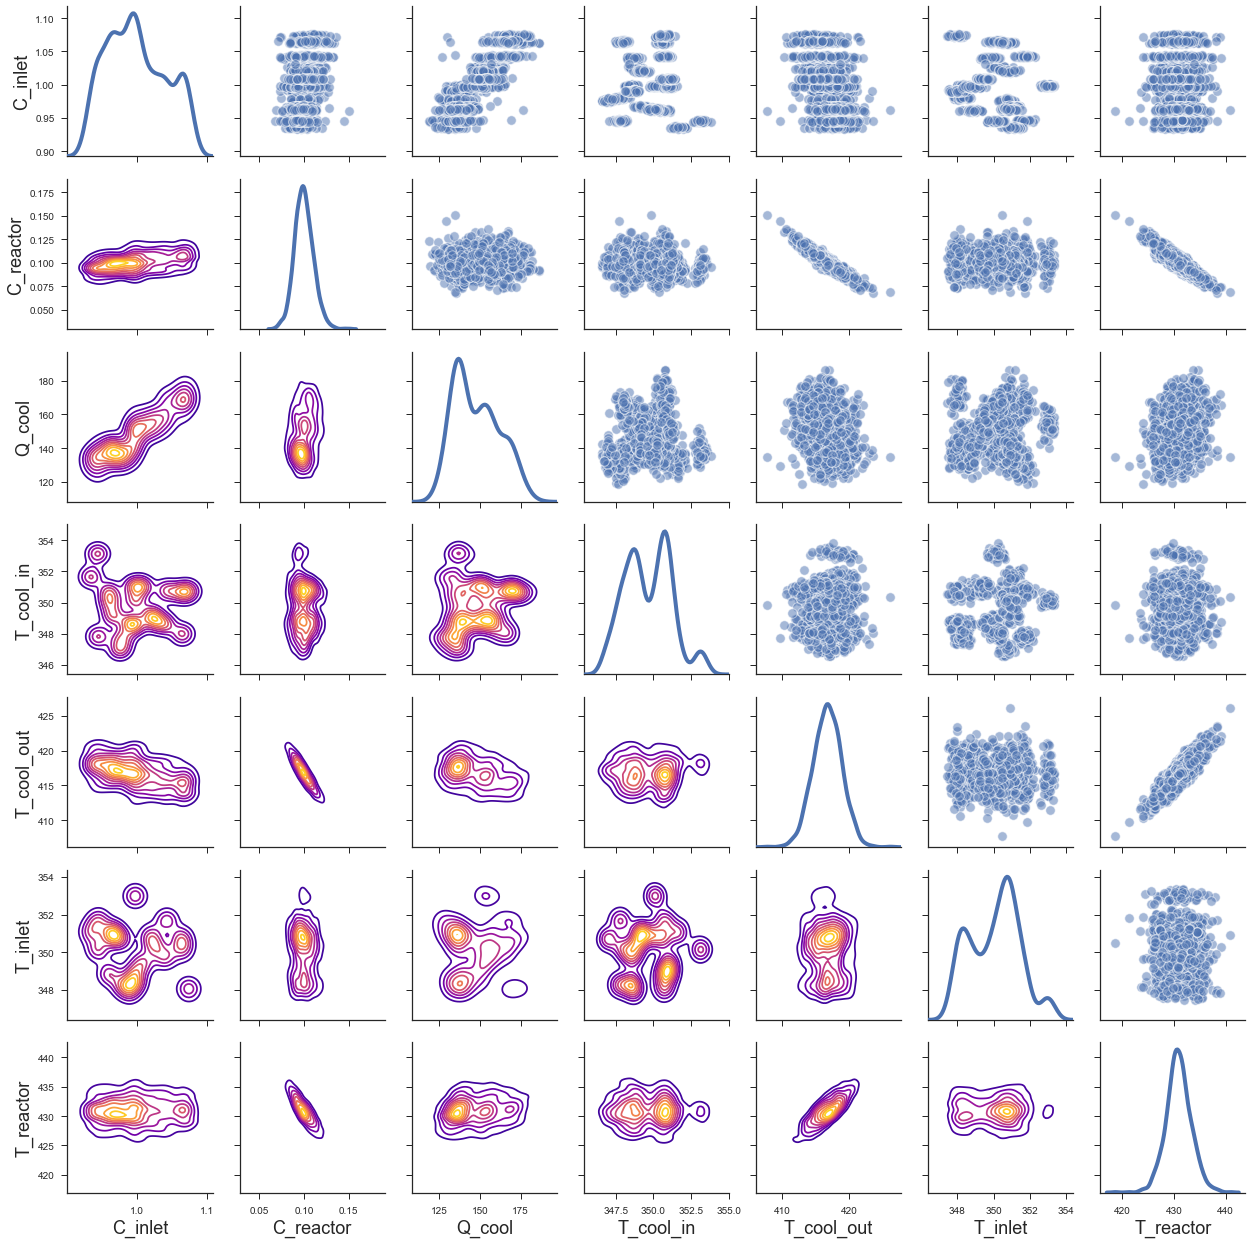

In [16]:
import matplotlib
matplotlib.pyplot.rcParams["axes.labelsize"] = 18
g = sns.PairGrid(normal, diag_sharey=False)
axes = g.axes
g.map_upper(matplotlib.pyplot.scatter,  linewidths=1, 
            edgecolor="w", s=90, alpha = 0.5)
g.map_diag(sns.kdeplot, lw = 4, legend=False)
g.map_lower(sns.kdeplot, cmap=cm.plasma)
matplotlib.pyplot.show()